# ARC Prize 2024

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from pathlib import Path

from arc2024.data import Dataset
from arc2024.utils import plot

from arc2024.models.vision_transformer import PatchEmbedding

## Prepare Datasets and DataLoaders

In [2]:
dataset_dir = Path('datasets')

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = Dataset(
    dataset_dir=dataset_dir,
    mode='training',
    permutations=True
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataset = Dataset(
    dataset_dir=dataset_dir,
    mode='evaluation'
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

## Visualize Random Challenge from Training Dataset


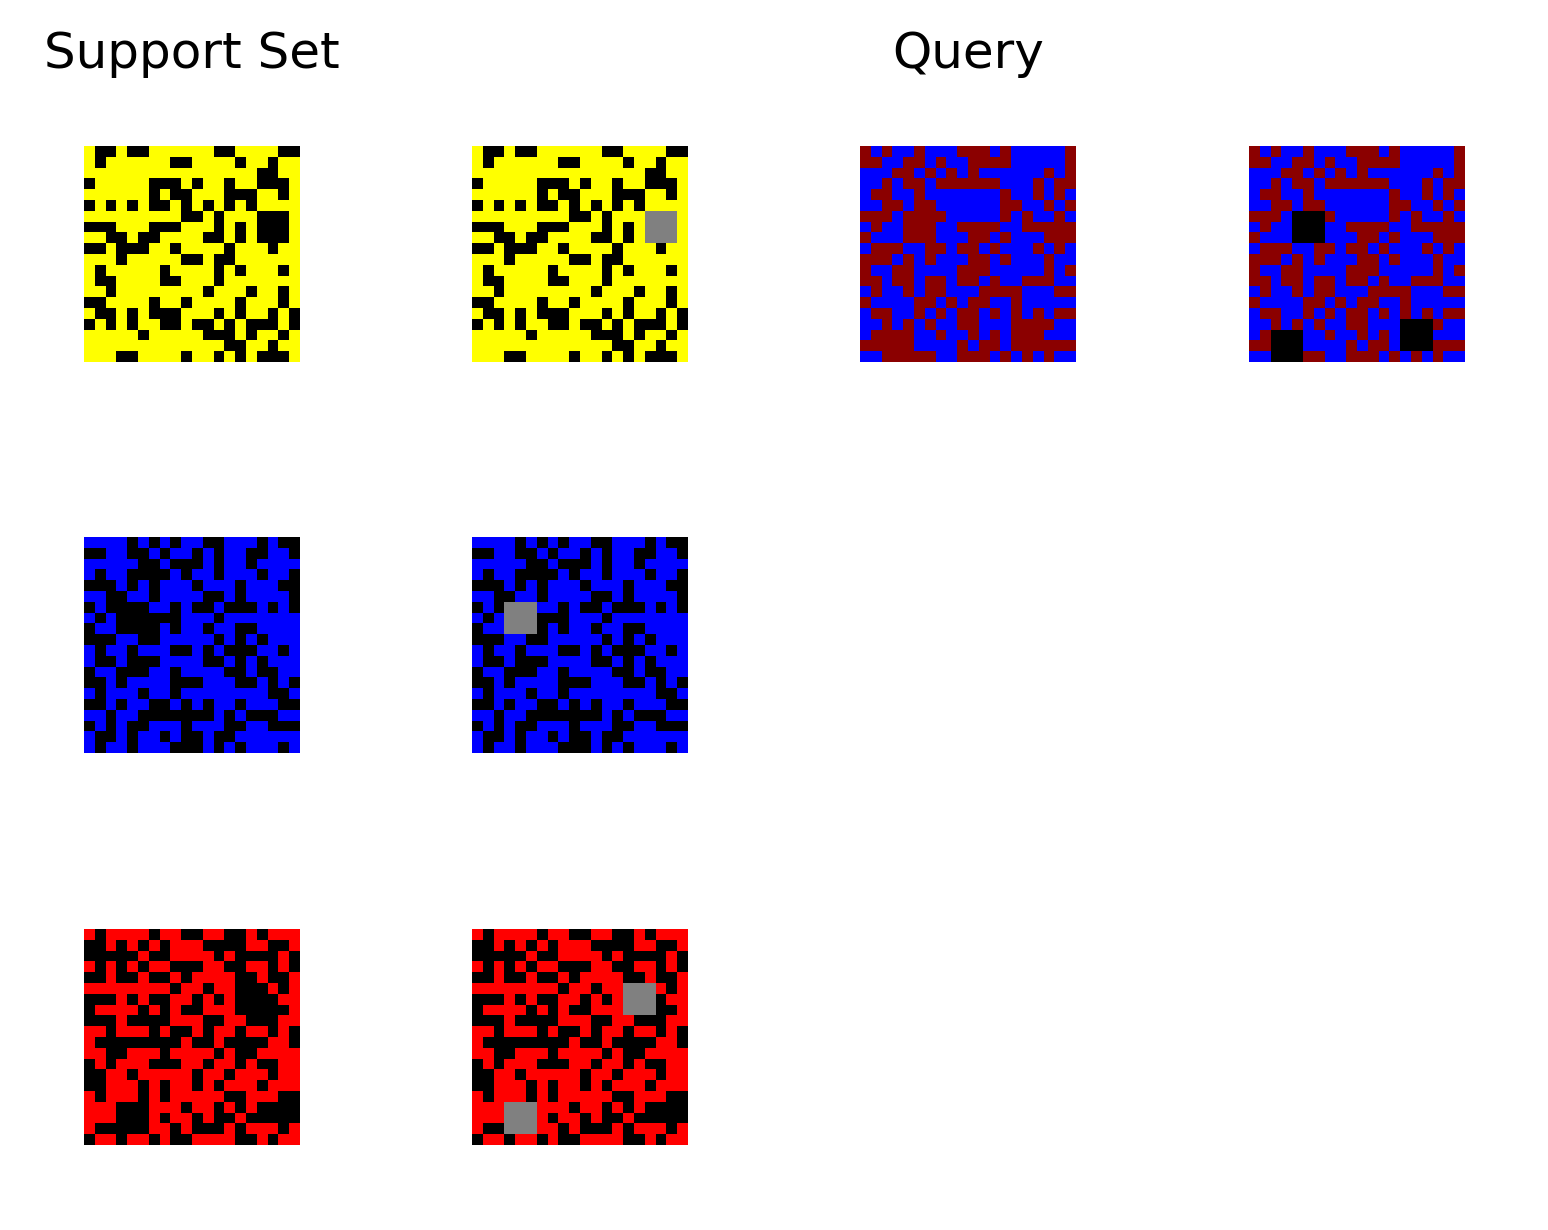

In [3]:
import random

# random.seed(42)
plot_n_support_set_items = 3

support_set_inputs, support_set_outputs, query_inputs, query_outputs = random.choice(train_dataset)

plot.challenge(
    support_set_inputs=support_set_inputs[:plot_n_support_set_items],
    support_set_outputs=support_set_outputs[:plot_n_support_set_items],
    query_inputs=query_inputs,
    query_outputs=query_outputs
)

## Create Vision Transformer (ViT) Model

### Equation 1: Split data into patches and creating the class, position and patch embedding

$$
\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

- $H$ = Height = 30
- $W$ = Width = 30
- $C$ = Color channels
- $P$ = Patch size (= 30)
- $N$ = number of patches = number of items in support set
- $D$ = constant latent vector size = embedding dimension (see Table 1)

- Input shape = $H * W * C = 30 * 30 * 1 = 900$
- Ouptut shape = $N * (P^{2} * C) = N * (900 * 1) = N * 900$

In [4]:
embedding_layer_input_shape = (1, 30, 30)
embedding_layer_output_shape = (1, 900)

Input shape [support set]: torch.Size([1, 30, 30])
Output shape [support set]: torch.Size([1, 30, 30])
Input shape [query]: torch.Size([1, 30, 30])
Output shape [query]: torch.Size([1, 30, 30])
Input shape flattened [support set]: torch.Size([1, 900])
Input shape flattened [query]: torch.Size([1, 900])
shape1 : torch.Size([1, 1, 60, 30])
shape2 : torch.Size([1, 900, 2, 1])
shape3 : torch.Size([1, 900, 2])


(-0.5, 899.5, 1.5, -0.5)

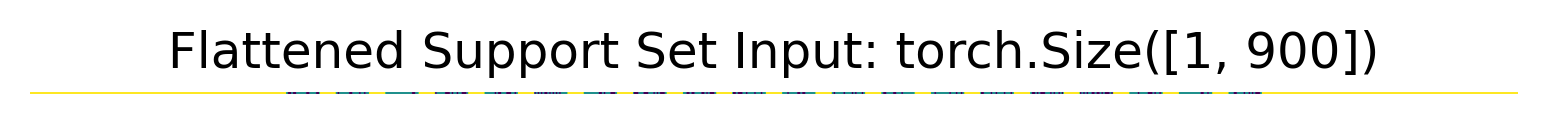

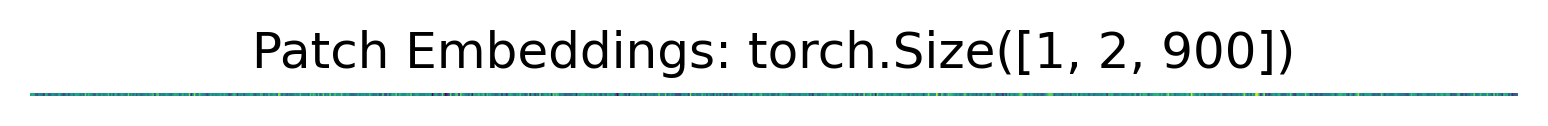

In [9]:


print(f"Input shape [support set]: {support_set_inputs[0].shape}")
print(f"Output shape [support set]: {support_set_outputs[0].shape}")

print(f"Input shape [query]: {query_inputs[0].shape}")
print(f"Output shape [query]: {query_outputs[0].shape}")


flatten = torch.nn.Flatten(start_dim=1, # flatten feature_map_height (dimension 2)
                     end_dim=2) # flatten feature_map_width (dimension 3)

flattened_support_set_input = flatten(support_set_inputs[0])
print(f"Input shape flattened [support set]: {flattened_support_set_input.shape}")
print(f"Input shape flattened [query]: {flatten(query_inputs[0]).shape}")

plt.figure(dpi=300)
plt.imshow(flattened_support_set_input)
plt.title(f"Flattened Support Set Input: {flattened_support_set_input.shape}")
plt.axis(False)

support_set_input_and_output = torch.cat((
    support_set_inputs[0].squeeze(),
    support_set_outputs[0].squeeze()
)).unsqueeze(0).to(dtype=torch.float)

patch_embedding = PatchEmbedding()
patch_embeddings = patch_embedding.forward(
    support_set_input_and_output.unsqueeze(0) # add extra batch dimension to avoid error
)

plt.figure(dpi=300)
plt.imshow(patch_embeddings.squeeze(0).detach().numpy())
plt.title(f"Patch Embeddings: {patch_embeddings.shape}")
plt.axis(False)

## Equation 2
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

### Equation 3

$$
\begin{aligned}
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

### Equation 4

$$\mathbf{y}=\operatorname{LN}\left(\mathbf{z}_L^0\right)$$